# Alexis (Modelling)

## Model developement, Anomaly detection, Accuracy measurement

2024-08-22 19:26:14,056 - INFO - load_data: Time: 0.0020s, Memory Change: 0.02MB
2024-08-22 19:26:14,056 - INFO - compute_checksum: Time: 0.0000s, Memory Change: 0.00MB
2024-08-22 19:26:14,057 - INFO - split_data: Time: 0.0000s, Memory Change: 0.00MB
2024-08-22 19:26:14,058 - INFO - normalize_data: Time: 0.0000s, Memory Change: 0.00MB
2024-08-22 19:26:14,075 - INFO - train_model: Time: 0.0160s, Memory Change: 0.00MB
2024-08-22 19:26:14,077 - INFO - evaluate_model: Time: 0.0020s, Memory Change: 0.00MB


Checksums comparison - MSE: 0.0000
The last 50 values are consistent with the golden reference.
Early stopping at epoch 11
Final Model Performance on Validation Data
MSE Loss: 1.0293
MAE Loss: 0.7593
Accuracy: 88.33%
No anomaly detected


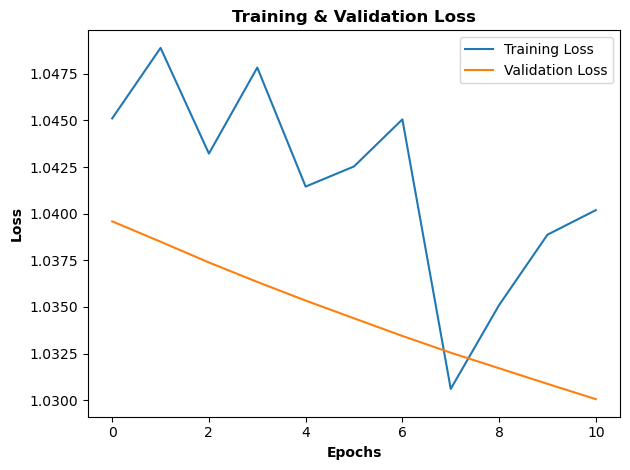

Total Execution Time: 0.0200 seconds
Total Memory Overhead: 1.26 MB


In [319]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import psutil
import logging

# Setup logging for performance monitoring
logging.basicConfig(filename='performance.log', level=logging.INFO)

# Global variables to accumulate total time and memory
total_time = 0
peak_memory = 0

# Function to measure the execution time and memory usage of a function
def monitor_performance(func):
    def wrapper(*args, **kwargs):
        global total_time, peak_memory
        start_time = time.time()
        process = psutil.Process()
        start_mem = process.memory_info().rss / (1024 * 1024)  # Convert to MB
        result = func(*args, **kwargs)
        end_time = time.time()
        end_mem = process.memory_info().rss / (1024 * 1024)  # Convert to MB
        exec_time = end_time - start_time
        mem_usage = end_mem - start_mem
        peak_mem = process.memory_info().vms / (1024 * 1024)  # Virtual memory size for peak usage
        logging.info(f"{func.__name__}: Time: {exec_time:.4f}s, Memory Change: {mem_usage:.2f}MB")
        total_time += exec_time
        peak_memory = max(peak_memory, peak_mem)
        return result
    return wrapper

# Class for handling the entire Alexis process
class AlexisAnomalyDetector:
    def __init__(self, data_path):
        self.data_path = data_path
        self.data = None
        self.model = None
        self.mean = None
        self.std = None
        self.train_data = None
        self.val_data = None
        self.train_losses = []
        self.val_losses = []

    @monitor_performance
    def load_data(self):
        self.data = pd.read_csv(self.data_path).dropna()

    @monitor_performance
    def compute_checksum(self):
        last_50_values = self.data.values[-50:]
        golden_reference = np.full_like(last_50_values, 4.48)
        mse_checksum = ((last_50_values - golden_reference) ** 2).mean()
        anomaly_detected = mse_checksum > 0.01
        return mse_checksum, anomaly_detected

    @monitor_performance
    def split_data(self, test_size=0.3, random_state=42):
        self.train_data, self.val_data = train_test_split(self.data, test_size=test_size, random_state=random_state)

    @monitor_performance
    def normalize_data(self):
        tensor_train_data = torch.tensor(self.train_data.values, dtype=torch.float32)
        tensor_val_data = torch.tensor(self.val_data.values, dtype=torch.float32)
        self.mean = tensor_train_data.mean(dim=0)
        self.std = tensor_train_data.std(dim=0)
        self.tensor_train_data = (tensor_train_data - self.mean) / self.std
        self.tensor_val_data = (tensor_val_data - self.mean) / self.std

    class Autoencoder(torch.nn.Module):
        def __init__(self):
            super(AlexisAnomalyDetector.Autoencoder, self).__init__()
            self.encoder = torch.nn.Sequential(
                torch.nn.Linear(1, 16),  # Reduced complexity
                torch.nn.ReLU(),
                torch.nn.Dropout(0.3),  # Reduced dropout
                torch.nn.Linear(16, 4),
                torch.nn.ReLU()
            )
            self.decoder = torch.nn.Sequential(
                torch.nn.Linear(4, 16),  # Reduced complexity
                torch.nn.ReLU(),
                torch.nn.Dropout(0.3),  # Reduced dropout
                torch.nn.Linear(16, 1)
            )

        def forward(self, x):
            x = self.encoder(x)
            x = self.decoder(x)
            return x

    @monitor_performance
    def train_model(self, num_epochs=50, patience=10, lr=0.005):
        self.model = self.Autoencoder()
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.SGD(self.model.parameters(), lr=lr)  # Changed optimizer to SGD
        best_val_loss = float('inf')
        count = 0

        for epoch in range(num_epochs):
            # Forward pass - Training
            self.model.train()
            train_outputs = self.model(self.tensor_train_data)
            train_loss = criterion(train_outputs, self.tensor_train_data)
            self.train_losses.append(train_loss.item())

            # Forward pass - Validation
            self.model.eval()
            with torch.no_grad():
                val_outputs = self.model(self.tensor_val_data)
                val_loss = criterion(val_outputs, self.tensor_val_data)
                self.val_losses.append(val_loss.item())

            # Backward and optimize - Training
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            # Early stopping based on validation loss
            if val_loss.item() < best_val_loss - 0.1:
                best_val_loss = val_loss.item()
                count = 0
            else:
                count += 1
                if count == patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    break

    @monitor_performance
    def evaluate_model(self):
        self.model.eval()
        with torch.no_grad():
            val_outputs = self.model(self.tensor_val_data)
            mse_loss = torch.nn.MSELoss()(val_outputs, self.tensor_val_data)
            mae_loss = torch.abs(val_outputs - self.tensor_val_data).mean()

        mse_per_data_point = ((val_outputs - self.tensor_val_data) ** 2).mean(dim=1)
        q1 = np.quantile(mse_per_data_point.numpy(), 0.25)
        q3 = np.quantile(mse_per_data_point.numpy(), 0.75)
        iqr = q3 - q1
        dynamic_threshold = q3 + 1.5 * iqr

        accuracy = (mse_per_data_point < dynamic_threshold).float().mean().item()
        
        return mse_loss, mae_loss, accuracy

    def plot_losses(self):
        fig, ax = plt.subplots()
        ax.plot(self.train_losses, label='Training Loss')
        ax.plot(self.val_losses, label='Validation Loss')
        ax.set_title('Training & Validation Loss', fontweight='bold')
        ax.set_xlabel('Epochs', fontweight='bold')
        ax.set_ylabel('Loss', fontweight='bold')
        ax.legend()
        plt.tight_layout()
        plt.show()

# Track memory before starting the execution
start_memory = psutil.Process().memory_info().rss / (1024 * 1024)  # Memory in MB

# Example usage:
detector = AlexisAnomalyDetector('Normal2_corrected.csv')
detector.load_data()
checksum, anomaly_detected = detector.compute_checksum()
print(f"Checksums comparison - MSE: {checksum:.4f}")
if anomaly_detected:
    print("The last 50 values deviate from the golden reference.")
else:
    print("The last 50 values are consistent with the golden reference.")

detector.split_data()
detector.normalize_data()
detector.train_model()
mse_loss, mae_loss, accuracy = detector.evaluate_model()

print("\033[1mFinal Model Performance on Validation Data\033[0m")
print(f"MSE Loss: {mse_loss.item():.4f}")
print(f"MAE Loss: {mae_loss.item():.4f}")
print(f"Accuracy: {accuracy:.2%}")
if anomaly_detected:
    print("\033[1mAnomaly detected\033[0m")
else:
    print("\033[1mNo anomaly detected\033[0m")

detector.plot_losses()

# Track memory after execution
end_memory = psutil.Process().memory_info().rss / (1024 * 1024)  # Memory in MB

# Print total time and memory overhead
print(f"\033[1mTotal Execution Time: {total_time:.4f} seconds\033[0m")
print(f"\033[1mTotal Memory Overhead: {end_memory - start_memory:.2f} MB\033[0m")


2024-08-22 19:28:49,806 - INFO - load_data: Time: 0.0010s, Memory Change: 0.00MB
2024-08-22 19:28:49,806 - INFO - compute_checksum: Time: 0.0000s, Memory Change: 0.00MB
2024-08-22 19:28:49,807 - INFO - split_data: Time: 0.0000s, Memory Change: 0.00MB
2024-08-22 19:28:49,808 - INFO - normalize_data: Time: 0.0000s, Memory Change: 0.00MB
2024-08-22 19:28:49,825 - INFO - train_model: Time: 0.0165s, Memory Change: 0.00MB
2024-08-22 19:28:49,827 - INFO - evaluate_model: Time: 0.0000s, Memory Change: 0.00MB


Checksums comparison - MSE: 20.7066
The last 50 values deviate from the golden reference.
Early stopping at epoch 11
Final Model Performance on Validation Data
MSE Loss: 0.9316
MAE Loss: 0.6804
Accuracy: 91.67%
Anomaly detected


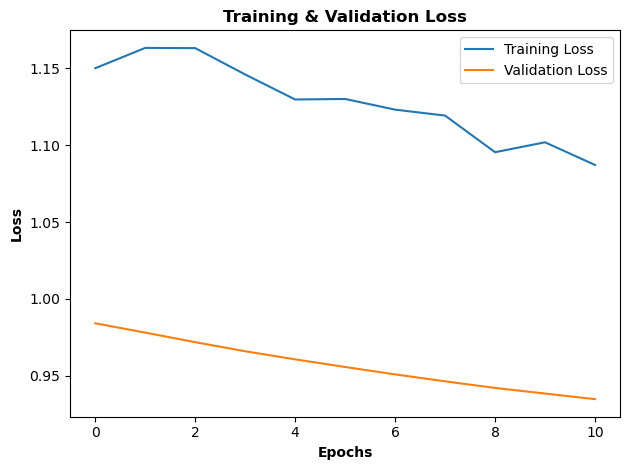

Total Execution Time: 0.0175 seconds
Total Memory Overhead: 1.14 MB


In [323]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import psutil
import logging

# Setup logging for performance monitoring
logging.basicConfig(filename='performance.log', level=logging.INFO)

# Global variables to accumulate total time and memory
total_time = 0
peak_memory = 0

# Function to measure the execution time and memory usage of a function
def monitor_performance(func):
    def wrapper(*args, **kwargs):
        global total_time, peak_memory
        start_time = time.time()
        process = psutil.Process()
        start_mem = process.memory_info().rss / (1024 * 1024)  # Convert to MB
        result = func(*args, **kwargs)
        end_time = time.time()
        end_mem = process.memory_info().rss / (1024 * 1024)  # Convert to MB
        exec_time = end_time - start_time
        mem_usage = end_mem - start_mem
        peak_mem = process.memory_info().vms / (1024 * 1024)  # Virtual memory size for peak usage
        logging.info(f"{func.__name__}: Time: {exec_time:.4f}s, Memory Change: {mem_usage:.2f}MB")
        total_time += exec_time
        peak_memory = max(peak_memory, peak_mem)
        return result
    return wrapper

# Class for handling the entire Alexis process
class AlexisAnomalyDetector:
    def __init__(self, data_path):
        self.data_path = data_path
        self.data = None
        self.model = None
        self.mean = None
        self.std = None
        self.train_data = None
        self.val_data = None
        self.train_losses = []
        self.val_losses = []

    @monitor_performance
    def load_data(self):
        self.data = pd.read_csv(self.data_path).dropna()

    @monitor_performance
    def compute_checksum(self):
        last_50_values = self.data.values[-50:]
        golden_reference = np.full_like(last_50_values, 4.48)
        mse_checksum = ((last_50_values - golden_reference) ** 2).mean()
        anomaly_detected = mse_checksum > 0.01
        return mse_checksum, anomaly_detected

    @monitor_performance
    def split_data(self, test_size=0.3, random_state=42):
        self.train_data, self.val_data = train_test_split(self.data, test_size=test_size, random_state=random_state)

    @monitor_performance
    def normalize_data(self):
        tensor_train_data = torch.tensor(self.train_data.values, dtype=torch.float32)
        tensor_val_data = torch.tensor(self.val_data.values, dtype=torch.float32)
        self.mean = tensor_train_data.mean(dim=0)
        self.std = tensor_train_data.std(dim=0)
        self.tensor_train_data = (tensor_train_data - self.mean) / self.std
        self.tensor_val_data = (tensor_val_data - self.mean) / self.std

    class Autoencoder(torch.nn.Module):
        def __init__(self):
            super(AlexisAnomalyDetector.Autoencoder, self).__init__()
            self.encoder = torch.nn.Sequential(
                torch.nn.Linear(1, 16),  # Reduced complexity
                torch.nn.ReLU(),
                torch.nn.Dropout(0.3),  # Reduced dropout
                torch.nn.Linear(16, 4),
                torch.nn.ReLU()
            )
            self.decoder = torch.nn.Sequential(
                torch.nn.Linear(4, 16),  # Reduced complexity
                torch.nn.ReLU(),
                torch.nn.Dropout(0.3),  # Reduced dropout
                torch.nn.Linear(16, 1)
            )

        def forward(self, x):
            x = self.encoder(x)
            x = self.decoder(x)
            return x

    @monitor_performance
    def train_model(self, num_epochs=50, patience=10, lr=0.005):
        self.model = self.Autoencoder()
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.SGD(self.model.parameters(), lr=lr)  # Changed optimizer to SGD
        best_val_loss = float('inf')
        count = 0

        for epoch in range(num_epochs):
            # Forward pass - Training
            self.model.train()
            train_outputs = self.model(self.tensor_train_data)
            train_loss = criterion(train_outputs, self.tensor_train_data)
            self.train_losses.append(train_loss.item())

            # Forward pass - Validation
            self.model.eval()
            with torch.no_grad():
                val_outputs = self.model(self.tensor_val_data)
                val_loss = criterion(val_outputs, self.tensor_val_data)
                self.val_losses.append(val_loss.item())

            # Backward and optimize - Training
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            # Early stopping based on validation loss
            if val_loss.item() < best_val_loss - 0.1:
                best_val_loss = val_loss.item()
                count = 0
            else:
                count += 1
                if count == patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    break

    @monitor_performance
    def evaluate_model(self):
        self.model.eval()
        with torch.no_grad():
            val_outputs = self.model(self.tensor_val_data)
            mse_loss = torch.nn.MSELoss()(val_outputs, self.tensor_val_data)
            mae_loss = torch.abs(val_outputs - self.tensor_val_data).mean()

        mse_per_data_point = ((val_outputs - self.tensor_val_data) ** 2).mean(dim=1)
        q1 = np.quantile(mse_per_data_point.numpy(), 0.25)
        q3 = np.quantile(mse_per_data_point.numpy(), 0.75)
        iqr = q3 - q1
        dynamic_threshold = q3 + 1.5 * iqr

        accuracy = (mse_per_data_point < dynamic_threshold).float().mean().item()
        
        return mse_loss, mae_loss, accuracy

    def plot_losses(self):
        fig, ax = plt.subplots()
        ax.plot(self.train_losses, label='Training Loss')
        ax.plot(self.val_losses, label='Validation Loss')
        ax.set_title('Training & Validation Loss', fontweight='bold')
        ax.set_xlabel('Epochs', fontweight='bold')
        ax.set_ylabel('Loss', fontweight='bold')
        ax.legend()
        plt.tight_layout()
        plt.show()

# Track memory before starting the execution
start_memory = psutil.Process().memory_info().rss / (1024 * 1024)  # Memory in MB

# Example usage:
detector = AlexisAnomalyDetector('Trojan1_corrected.csv')
detector.load_data()
checksum, anomaly_detected = detector.compute_checksum()
print(f"Checksums comparison - MSE: {checksum:.4f}")
if anomaly_detected:
    print("The last 50 values deviate from the golden reference.")
else:
    print("The last 50 values are consistent with the golden reference.")

detector.split_data()
detector.normalize_data()
detector.train_model()
mse_loss, mae_loss, accuracy = detector.evaluate_model()

print("\033[1mFinal Model Performance on Validation Data\033[0m")
print(f"MSE Loss: {mse_loss.item():.4f}")
print(f"MAE Loss: {mae_loss.item():.4f}")
print(f"Accuracy: {accuracy:.2%}")
if anomaly_detected:
    print("\033[1mAnomaly detected\033[0m")
else:
    print("\033[1mNo anomaly detected\033[0m")

detector.plot_losses()

# Track memory after execution
end_memory = psutil.Process().memory_info().rss / (1024 * 1024)  # Memory in MB

# Print total time and memory overhead
print(f"\033[1mTotal Execution Time: {total_time:.4f} seconds\033[0m")
print(f"\033[1mTotal Memory Overhead: {end_memory - start_memory:.2f} MB\033[0m")


2024-08-22 19:31:18,268 - INFO - load_data: Time: 0.0010s, Memory Change: 0.00MB
2024-08-22 19:31:18,269 - INFO - compute_checksum: Time: 0.0000s, Memory Change: 0.00MB
2024-08-22 19:31:18,270 - INFO - split_data: Time: 0.0010s, Memory Change: 0.00MB
2024-08-22 19:31:18,271 - INFO - normalize_data: Time: 0.0010s, Memory Change: 0.00MB
2024-08-22 19:31:18,288 - INFO - train_model: Time: 0.0170s, Memory Change: 0.00MB
2024-08-22 19:31:18,289 - INFO - evaluate_model: Time: 0.0010s, Memory Change: 0.00MB


Checksums comparison - MSE: 20.7066
The last 50 values deviate from the golden reference.
Early stopping at epoch 11
Final Model Performance on Validation Data
MSE Loss: 0.9141
MAE Loss: 0.6683
Accuracy: 91.33%
Anomaly detected


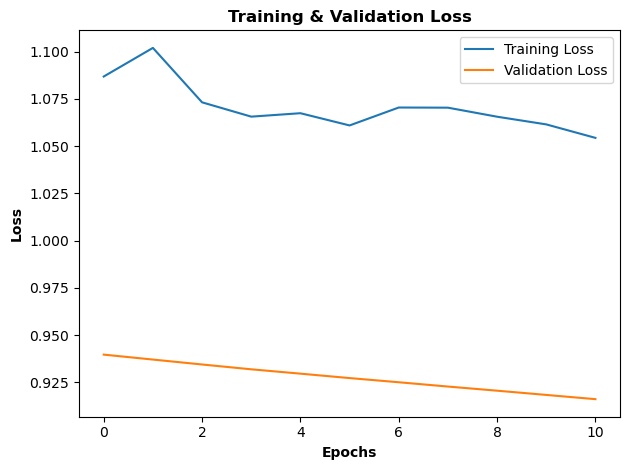

Total Execution Time: 0.0210 seconds
Total Memory Overhead: 1.17 MB


In [338]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import psutil
import logging

# Setup logging for performance monitoring
logging.basicConfig(filename='performance.log', level=logging.INFO)

# Global variables to accumulate total time and memory
total_time = 0
peak_memory = 0

# Function to measure the execution time and memory usage of a function
def monitor_performance(func):
    def wrapper(*args, **kwargs):
        global total_time, peak_memory
        start_time = time.time()
        process = psutil.Process()
        start_mem = process.memory_info().rss / (1024 * 1024)  # Convert to MB
        result = func(*args, **kwargs)
        end_time = time.time()
        end_mem = process.memory_info().rss / (1024 * 1024)  # Convert to MB
        exec_time = end_time - start_time
        mem_usage = end_mem - start_mem
        peak_mem = process.memory_info().vms / (1024 * 1024)  # Virtual memory size for peak usage
        logging.info(f"{func.__name__}: Time: {exec_time:.4f}s, Memory Change: {mem_usage:.2f}MB")
        total_time += exec_time
        peak_memory = max(peak_memory, peak_mem)
        return result
    return wrapper

# Class for handling the entire Alexis process
class AlexisAnomalyDetector:
    def __init__(self, data_path):
        self.data_path = data_path
        self.data = None
        self.model = None
        self.mean = None
        self.std = None
        self.train_data = None
        self.val_data = None
        self.train_losses = []
        self.val_losses = []

    @monitor_performance
    def load_data(self):
        self.data = pd.read_csv(self.data_path).dropna()

    @monitor_performance
    def compute_checksum(self):
        last_50_values = self.data.values[-50:]
        golden_reference = np.full_like(last_50_values, 4.48)
        mse_checksum = ((last_50_values - golden_reference) ** 2).mean()
        anomaly_detected = mse_checksum > 0.01
        return mse_checksum, anomaly_detected

    @monitor_performance
    def split_data(self, test_size=0.3, random_state=42):
        self.train_data, self.val_data = train_test_split(self.data, test_size=test_size, random_state=random_state)

    @monitor_performance
    def normalize_data(self):
        tensor_train_data = torch.tensor(self.train_data.values, dtype=torch.float32)
        tensor_val_data = torch.tensor(self.val_data.values, dtype=torch.float32)
        self.mean = tensor_train_data.mean(dim=0)
        self.std = tensor_train_data.std(dim=0)
        self.tensor_train_data = (tensor_train_data - self.mean) / self.std
        self.tensor_val_data = (tensor_val_data - self.mean) / self.std

    class Autoencoder(torch.nn.Module):
        def __init__(self):
            super(AlexisAnomalyDetector.Autoencoder, self).__init__()
            self.encoder = torch.nn.Sequential(
                torch.nn.Linear(1, 16),  # Reduced complexity
                torch.nn.ReLU(),
                torch.nn.Dropout(0.3),  # Reduced dropout
                torch.nn.Linear(16, 4),
                torch.nn.ReLU()
            )
            self.decoder = torch.nn.Sequential(
                torch.nn.Linear(4, 16),  # Reduced complexity
                torch.nn.ReLU(),
                torch.nn.Dropout(0.3),  # Reduced dropout
                torch.nn.Linear(16, 1)
            )

        def forward(self, x):
            x = self.encoder(x)
            x = self.decoder(x)
            return x

    @monitor_performance
    def train_model(self, num_epochs=50, patience=10, lr=0.005):
        self.model = self.Autoencoder()
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.SGD(self.model.parameters(), lr=lr)  # Changed optimizer to SGD
        best_val_loss = float('inf')
        count = 0

        for epoch in range(num_epochs):
            # Forward pass - Training
            self.model.train()
            train_outputs = self.model(self.tensor_train_data)
            train_loss = criterion(train_outputs, self.tensor_train_data)
            self.train_losses.append(train_loss.item())

            # Forward pass - Validation
            self.model.eval()
            with torch.no_grad():
                val_outputs = self.model(self.tensor_val_data)
                val_loss = criterion(val_outputs, self.tensor_val_data)
                self.val_losses.append(val_loss.item())

            # Backward and optimize - Training
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            # Early stopping based on validation loss
            if val_loss.item() < best_val_loss - 0.1:
                best_val_loss = val_loss.item()
                count = 0
            else:
                count += 1
                if count == patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    break

    @monitor_performance
    def evaluate_model(self):
        self.model.eval()
        with torch.no_grad():
            val_outputs = self.model(self.tensor_val_data)
            mse_loss = torch.nn.MSELoss()(val_outputs, self.tensor_val_data)
            mae_loss = torch.abs(val_outputs - self.tensor_val_data).mean()

        mse_per_data_point = ((val_outputs - self.tensor_val_data) ** 2).mean(dim=1)
        q1 = np.quantile(mse_per_data_point.numpy(), 0.25)
        q3 = np.quantile(mse_per_data_point.numpy(), 0.75)
        iqr = q3 - q1
        dynamic_threshold = q3 + 1.5 * iqr

        accuracy = (mse_per_data_point < dynamic_threshold).float().mean().item()
        
        return mse_loss, mae_loss, accuracy

    def plot_losses(self):
        fig, ax = plt.subplots()
        ax.plot(self.train_losses, label='Training Loss')
        ax.plot(self.val_losses, label='Validation Loss')
        ax.set_title('Training & Validation Loss', fontweight='bold')
        ax.set_xlabel('Epochs', fontweight='bold')
        ax.set_ylabel('Loss', fontweight='bold')
        ax.legend()
        plt.tight_layout()
        plt.show()

# Track memory before starting the execution
start_memory = psutil.Process().memory_info().rss / (1024 * 1024)  # Memory in MB

# Example usage:
detector = AlexisAnomalyDetector('Trojan2_corrected.csv')
detector.load_data()
checksum, anomaly_detected = detector.compute_checksum()
print(f"Checksums comparison - MSE: {checksum:.4f}")
if anomaly_detected:
    print("The last 50 values deviate from the golden reference.")
else:
    print("The last 50 values are consistent with the golden reference.")

detector.split_data()
detector.normalize_data()
detector.train_model()
mse_loss, mae_loss, accuracy = detector.evaluate_model()

print("\033[1mFinal Model Performance on Validation Data\033[0m")
print(f"MSE Loss: {mse_loss.item():.4f}")
print(f"MAE Loss: {mae_loss.item():.4f}")
print(f"Accuracy: {accuracy:.2%}")
if anomaly_detected:
    print("\033[1mAnomaly detected\033[0m")
else:
    print("\033[1mNo anomaly detected\033[0m")

detector.plot_losses()

# Track memory after execution
end_memory = psutil.Process().memory_info().rss / (1024 * 1024)  # Memory in MB

# Print total time and memory overhead
print(f"\033[1mTotal Execution Time: {total_time:.4f} seconds\033[0m")
print(f"\033[1mTotal Memory Overhead: {end_memory - start_memory:.2f} MB\033[0m")


2024-08-22 19:32:52,231 - INFO - load_data: Time: 0.0020s, Memory Change: 0.02MB
2024-08-22 19:32:52,231 - INFO - compute_checksum: Time: 0.0000s, Memory Change: 0.00MB
2024-08-22 19:32:52,232 - INFO - split_data: Time: 0.0010s, Memory Change: 0.00MB
2024-08-22 19:32:52,233 - INFO - normalize_data: Time: 0.0010s, Memory Change: 0.00MB
2024-08-22 19:32:52,248 - INFO - train_model: Time: 0.0150s, Memory Change: 0.00MB
2024-08-22 19:32:52,250 - INFO - evaluate_model: Time: 0.0010s, Memory Change: 0.00MB


Checksums comparison - MSE: 20.5883
The last 50 values deviate from the golden reference.
Early stopping at epoch 11
Final Model Performance on Validation Data
MSE Loss: 0.9169
MAE Loss: 0.7125
Accuracy: 90.33%
Anomaly detected


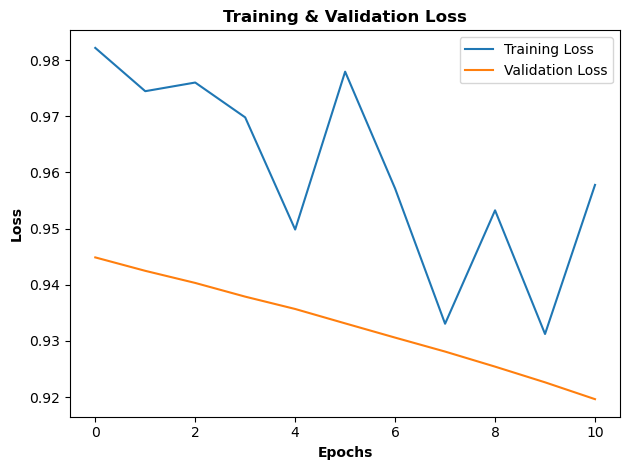

Total Execution Time: 0.0200 seconds
Total Memory Overhead: 1.16 MB


In [341]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import psutil
import logging

# Setup logging for performance monitoring
logging.basicConfig(filename='performance.log', level=logging.INFO)

# Global variables to accumulate total time and memory
total_time = 0
peak_memory = 0

# Function to measure the execution time and memory usage of a function
def monitor_performance(func):
    def wrapper(*args, **kwargs):
        global total_time, peak_memory
        start_time = time.time()
        process = psutil.Process()
        start_mem = process.memory_info().rss / (1024 * 1024)  # Convert to MB
        result = func(*args, **kwargs)
        end_time = time.time()
        end_mem = process.memory_info().rss / (1024 * 1024)  # Convert to MB
        exec_time = end_time - start_time
        mem_usage = end_mem - start_mem
        peak_mem = process.memory_info().vms / (1024 * 1024)  # Virtual memory size for peak usage
        logging.info(f"{func.__name__}: Time: {exec_time:.4f}s, Memory Change: {mem_usage:.2f}MB")
        total_time += exec_time
        peak_memory = max(peak_memory, peak_mem)
        return result
    return wrapper

# Class for handling the entire Alexis process
class AlexisAnomalyDetector:
    def __init__(self, data_path):
        self.data_path = data_path
        self.data = None
        self.model = None
        self.mean = None
        self.std = None
        self.train_data = None
        self.val_data = None
        self.train_losses = []
        self.val_losses = []

    @monitor_performance
    def load_data(self):
        self.data = pd.read_csv(self.data_path).dropna()

    @monitor_performance
    def compute_checksum(self):
        last_50_values = self.data.values[-50:]
        golden_reference = np.full_like(last_50_values, 4.48)
        mse_checksum = ((last_50_values - golden_reference) ** 2).mean()
        anomaly_detected = mse_checksum > 0.01
        return mse_checksum, anomaly_detected

    @monitor_performance
    def split_data(self, test_size=0.3, random_state=42):
        self.train_data, self.val_data = train_test_split(self.data, test_size=test_size, random_state=random_state)

    @monitor_performance
    def normalize_data(self):
        tensor_train_data = torch.tensor(self.train_data.values, dtype=torch.float32)
        tensor_val_data = torch.tensor(self.val_data.values, dtype=torch.float32)
        self.mean = tensor_train_data.mean(dim=0)
        self.std = tensor_train_data.std(dim=0)
        self.tensor_train_data = (tensor_train_data - self.mean) / self.std
        self.tensor_val_data = (tensor_val_data - self.mean) / self.std

    class Autoencoder(torch.nn.Module):
        def __init__(self):
            super(AlexisAnomalyDetector.Autoencoder, self).__init__()
            self.encoder = torch.nn.Sequential(
                torch.nn.Linear(1, 16),  # Reduced complexity
                torch.nn.ReLU(),
                torch.nn.Dropout(0.3),  # Reduced dropout
                torch.nn.Linear(16, 4),
                torch.nn.ReLU()
            )
            self.decoder = torch.nn.Sequential(
                torch.nn.Linear(4, 16),  # Reduced complexity
                torch.nn.ReLU(),
                torch.nn.Dropout(0.3),  # Reduced dropout
                torch.nn.Linear(16, 1)
            )

        def forward(self, x):
            x = self.encoder(x)
            x = self.decoder(x)
            return x

    @monitor_performance
    def train_model(self, num_epochs=50, patience=10, lr=0.005):
        self.model = self.Autoencoder()
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.SGD(self.model.parameters(), lr=lr)  # Changed optimizer to SGD
        best_val_loss = float('inf')
        count = 0

        for epoch in range(num_epochs):
            # Forward pass - Training
            self.model.train()
            train_outputs = self.model(self.tensor_train_data)
            train_loss = criterion(train_outputs, self.tensor_train_data)
            self.train_losses.append(train_loss.item())

            # Forward pass - Validation
            self.model.eval()
            with torch.no_grad():
                val_outputs = self.model(self.tensor_val_data)
                val_loss = criterion(val_outputs, self.tensor_val_data)
                self.val_losses.append(val_loss.item())

            # Backward and optimize - Training
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            # Early stopping based on validation loss
            if val_loss.item() < best_val_loss - 0.1:
                best_val_loss = val_loss.item()
                count = 0
            else:
                count += 1
                if count == patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    break

    @monitor_performance
    def evaluate_model(self):
        self.model.eval()
        with torch.no_grad():
            val_outputs = self.model(self.tensor_val_data)
            mse_loss = torch.nn.MSELoss()(val_outputs, self.tensor_val_data)
            mae_loss = torch.abs(val_outputs - self.tensor_val_data).mean()

        mse_per_data_point = ((val_outputs - self.tensor_val_data) ** 2).mean(dim=1)
        q1 = np.quantile(mse_per_data_point.numpy(), 0.25)
        q3 = np.quantile(mse_per_data_point.numpy(), 0.75)
        iqr = q3 - q1
        dynamic_threshold = q3 + 1.5 * iqr

        accuracy = (mse_per_data_point < dynamic_threshold).float().mean().item()
        
        return mse_loss, mae_loss, accuracy

    def plot_losses(self):
        fig, ax = plt.subplots()
        ax.plot(self.train_losses, label='Training Loss')
        ax.plot(self.val_losses, label='Validation Loss')
        ax.set_title('Training & Validation Loss', fontweight='bold')
        ax.set_xlabel('Epochs', fontweight='bold')
        ax.set_ylabel('Loss', fontweight='bold')
        ax.legend()
        plt.tight_layout()
        plt.show()

# Track memory before starting the execution
start_memory = psutil.Process().memory_info().rss / (1024 * 1024)  # Memory in MB

# Example usage:
detector = AlexisAnomalyDetector('Trojan3_corrected.csv')
detector.load_data()
checksum, anomaly_detected = detector.compute_checksum()
print(f"Checksums comparison - MSE: {checksum:.4f}")
if anomaly_detected:
    print("The last 50 values deviate from the golden reference.")
else:
    print("The last 50 values are consistent with the golden reference.")

detector.split_data()
detector.normalize_data()
detector.train_model()
mse_loss, mae_loss, accuracy = detector.evaluate_model()

print("\033[1mFinal Model Performance on Validation Data\033[0m")
print(f"MSE Loss: {mse_loss.item():.4f}")
print(f"MAE Loss: {mae_loss.item():.4f}")
print(f"Accuracy: {accuracy:.2%}")
if anomaly_detected:
    print("\033[1mAnomaly detected\033[0m")
else:
    print("\033[1mNo anomaly detected\033[0m")

detector.plot_losses()

# Track memory after execution
end_memory = psutil.Process().memory_info().rss / (1024 * 1024)  # Memory in MB

# Print total time and memory overhead
print(f"\033[1mTotal Execution Time: {total_time:.4f} seconds\033[0m")
print(f"\033[1mTotal Memory Overhead: {end_memory - start_memory:.2f} MB\033[0m")


## Testing for True and Flase positives

Checksums comparison - MSE: 20.7066
The last 50 values deviate from the golden reference.


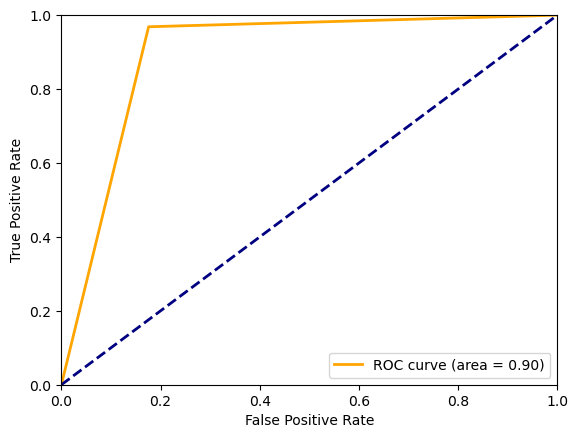

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


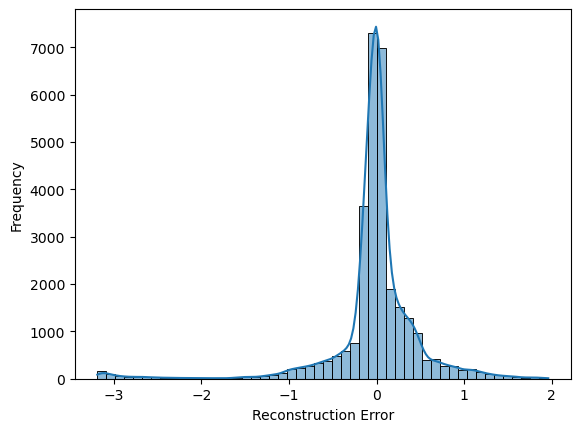

Final Model Performance
MSE Loss: 0.2923
MAE Loss: 0.2790
AUC: 0.90


In [222]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
import seaborn as sns

# Load bitstream data from file
data = pd.read_csv('Trojan2_corrected.csv').dropna()


last_50_values = data.values[-50:]
golden_reference = np.full_like(last_50_values, 4.48)

# Compare the Checksums using MSE for a more accurate comparison
mse_checksum = ((last_50_values - golden_reference) ** 2).mean()
anomaly_detected = mse_checksum > 0.01  # Adjusted threshold
print(f"Checksums comparison - MSE: {mse_checksum:.4f}")
if anomaly_detected:
    print("The last 50 values deviate from the golden reference.")
else:
    print("The last 50 values are consistent with the golden reference.")

# Define losses
train_losses = []
val_losses = []
true_labels = []
predictions = []

# Split data into training and validation sets
train_data, val_data = train_test_split(data, test_size=0.3, random_state=42)

# Convert bitstream data to PyTorch tensors
tensor_train_data = torch.tensor(train_data.values, dtype=torch.float32)
tensor_val_data = torch.tensor(val_data.values, dtype=torch.float32)

# Normalize input data based on training data
mean = tensor_train_data.mean(dim=0)
std = tensor_train_data.std(dim=0)
tensor_train_data = (tensor_train_data - mean) / std
tensor_val_data = (tensor_val_data - mean) / std

# Define autoencoder architecture with reduced dropout
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(1, 64),  # Increased number of neurons
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 16),
            torch.nn.ReLU()
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(16, 32),  # Increased number of neurons
            torch.nn.ReLU(),
            torch.nn.Linear(32, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Instantiate autoencoder model
model = Autoencoder()

# Define loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

# Train autoencoder on bitstream data with early stopping
num_epochs = 100
patience = 20
count = 0
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Forward pass - Training
    model.train()
    train_outputs = model(tensor_train_data)
    train_loss = criterion(train_outputs, tensor_train_data)
    train_losses.append(train_loss.item())

    # Forward pass - Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(tensor_val_data)
        val_loss = criterion(val_outputs, tensor_val_data)
        val_losses.append(val_loss.item())

        # Collecting true labels and predictions for ROC calculation
        predictions.extend(val_outputs.numpy().flatten())
        true_labels.extend(tensor_val_data.numpy().flatten())

    # Backward and optimize - Training
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # Early stopping based on validation loss
    if val_loss.item() < best_val_loss - 0.01:
        best_val_loss = val_loss.item()
        count = 0
    else:
        count += 1
        if count == patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

# Binarize the true labels and predictions
threshold = np.median(true_labels)  # You can also try other thresholds like mean
binary_true_labels = np.array(true_labels) > threshold
binary_predictions = np.array(predictions) > threshold

# Compute ROC Curve and AUC
fpr, tpr, _ = roc_curve(binary_true_labels, binary_predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot Reconstruction Error Distribution
reconstruction_errors = np.array(predictions) - np.array(true_labels)
plt.figure()
sns.histplot(reconstruction_errors, bins=50, kde=True)
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
# plt.title('Reconstruction Error Distribution')
plt.show()

# Calculate and print performance metrics
mse_loss = criterion(torch.tensor(predictions), torch.tensor(true_labels))
mae_loss = torch.abs(torch.tensor(predictions) - torch.tensor(true_labels)).mean()

print(f"Final Model Performance")
print(f"MSE Loss: {mse_loss.item():.4f}")
print(f"MAE Loss: {mae_loss.item():.4f}")
print(f"AUC: {roc_auc:.2f}")


Checksums comparison - MSE: 21.3383
The last 50 values deviate from the golden reference.


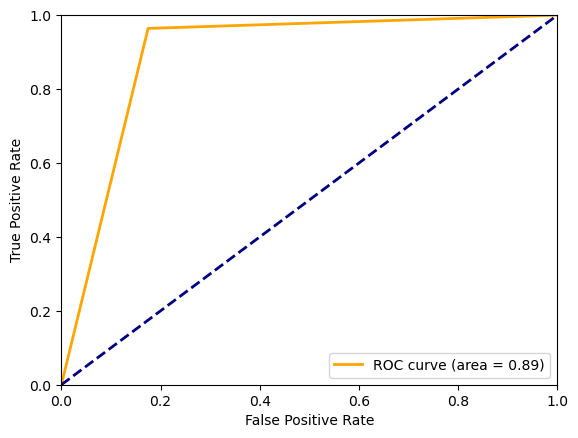

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


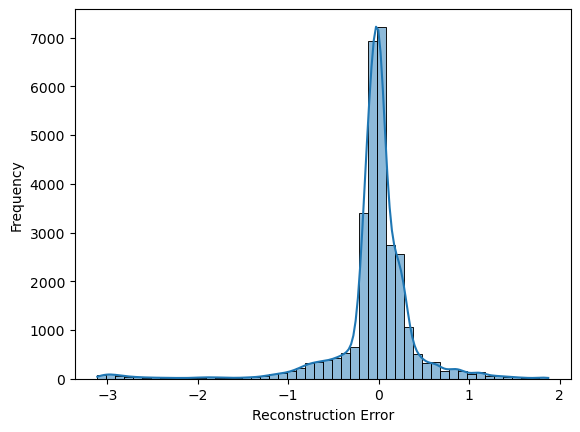

Final Model Performance
MSE Loss: 0.2357
MAE Loss: 0.2495
AUC: 0.89


In [261]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
import seaborn as sns

# Load bitstream data from file
data = pd.read_csv('Trojan4_corrected.csv').dropna()


last_50_values = data.values[-50:]
golden_reference = np.full_like(last_50_values, 4.48)

# Compare the Checksums using MSE for a more accurate comparison
mse_checksum = ((last_50_values - golden_reference) ** 2).mean()
anomaly_detected = mse_checksum > 0.01  # Adjusted threshold
print(f"Checksums comparison - MSE: {mse_checksum:.4f}")
if anomaly_detected:
    print("The last 50 values deviate from the golden reference.")
else:
    print("The last 50 values are consistent with the golden reference.")

# Define losses
train_losses = []
val_losses = []
true_labels = []
predictions = []

# Split data into training and validation sets
train_data, val_data = train_test_split(data, test_size=0.3, random_state=42)

# Convert bitstream data to PyTorch tensors
tensor_train_data = torch.tensor(train_data.values, dtype=torch.float32)
tensor_val_data = torch.tensor(val_data.values, dtype=torch.float32)

# Normalize input data based on training data
mean = tensor_train_data.mean(dim=0)
std = tensor_train_data.std(dim=0)
tensor_train_data = (tensor_train_data - mean) / std
tensor_val_data = (tensor_val_data - mean) / std

# Define autoencoder architecture with reduced dropout
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(1, 64),  # Increased number of neurons
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 16),
            torch.nn.ReLU()
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(16, 32),  # Increased number of neurons
            torch.nn.ReLU(),
            torch.nn.Linear(32, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Instantiate autoencoder model
model = Autoencoder()

# Define loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

# Train autoencoder on bitstream data with early stopping
num_epochs = 100
patience = 20
count = 0
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Forward pass - Training
    model.train()
    train_outputs = model(tensor_train_data)
    train_loss = criterion(train_outputs, tensor_train_data)
    train_losses.append(train_loss.item())

    # Forward pass - Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(tensor_val_data)
        val_loss = criterion(val_outputs, tensor_val_data)
        val_losses.append(val_loss.item())

        # Collecting true labels and predictions for ROC calculation
        predictions.extend(val_outputs.numpy().flatten())
        true_labels.extend(tensor_val_data.numpy().flatten())

    # Backward and optimize - Training
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # Early stopping based on validation loss
    if val_loss.item() < best_val_loss - 0.01:
        best_val_loss = val_loss.item()
        count = 0
    else:
        count += 1
        if count == patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

# Binarize the true labels and predictions
threshold = np.median(true_labels)  # You can also try other thresholds like mean
binary_true_labels = np.array(true_labels) > threshold
binary_predictions = np.array(predictions) > threshold

# Compute ROC Curve and AUC
fpr, tpr, _ = roc_curve(binary_true_labels, binary_predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot Reconstruction Error Distribution
reconstruction_errors = np.array(predictions) - np.array(true_labels)
plt.figure()
sns.histplot(reconstruction_errors, bins=50, kde=True)
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
# plt.title('Reconstruction Error Distribution')
plt.show()

# Calculate and print performance metrics
mse_loss = criterion(torch.tensor(predictions), torch.tensor(true_labels))
mae_loss = torch.abs(torch.tensor(predictions) - torch.tensor(true_labels)).mean()

print(f"Final Model Performance")
print(f"MSE Loss: {mse_loss.item():.4f}")
print(f"MAE Loss: {mae_loss.item():.4f}")
print(f"AUC: {roc_auc:.2f}")


Checksums comparison - MSE: 20.7066
The last 50 values deviate from the golden reference.


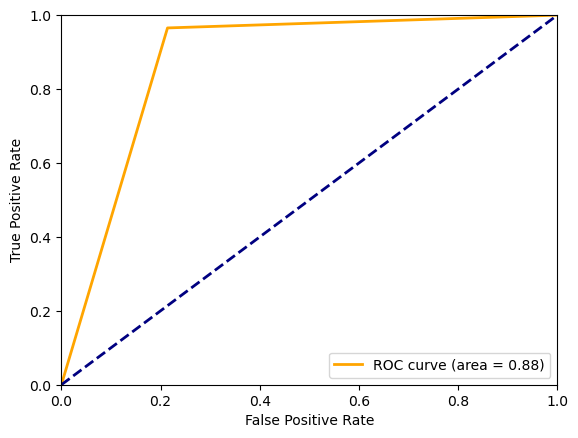

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


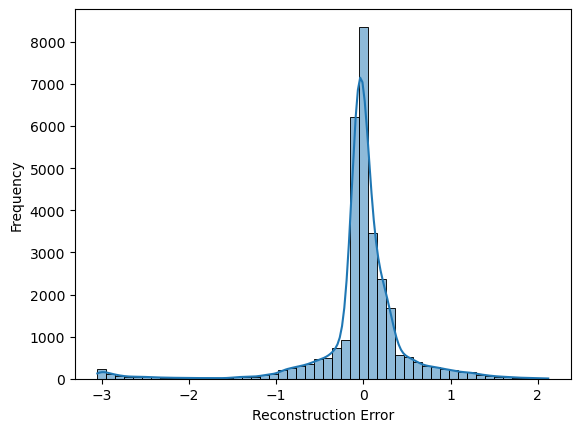

Final Model Performance
MSE Loss: 0.3203
MAE Loss: 0.2889
AUC: 0.88


In [274]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
import seaborn as sns

# Load bitstream data from file
data = pd.read_csv('Trojan1_corrected.csv').dropna()

last_50_values = data.values[-50:]
golden_reference = np.full_like(last_50_values, 4.48)

# Compare the Checksums using MSE for a more accurate comparison
mse_checksum = ((last_50_values - golden_reference) ** 2).mean()
anomaly_detected = mse_checksum > 0.01  # Adjusted threshold
print(f"Checksums comparison - MSE: {mse_checksum:.4f}")
if anomaly_detected:
    print("The last 50 values deviate from the golden reference.")
else:
    print("The last 50 values are consistent with the golden reference.")

# Define losses
train_losses = []
val_losses = []
true_labels = []
predictions = []

# Split data into training and validation sets
train_data, val_data = train_test_split(data, test_size=0.3, random_state=42)

# Convert bitstream data to PyTorch tensors
tensor_train_data = torch.tensor(train_data.values, dtype=torch.float32)
tensor_val_data = torch.tensor(val_data.values, dtype=torch.float32)

# Normalize input data based on training data
mean = tensor_train_data.mean(dim=0)
std = tensor_train_data.std(dim=0)
tensor_train_data = (tensor_train_data - mean) / std
tensor_val_data = (tensor_val_data - mean) / std

# Define autoencoder architecture with reduced dropout
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(1, 64),  # Increased number of neurons
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 16),
            torch.nn.ReLU()
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(16, 32),  # Increased number of neurons
            torch.nn.ReLU(),
            torch.nn.Linear(32, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Instantiate autoencoder model
model = Autoencoder()

# Define loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

# Train autoencoder on bitstream data with early stopping
num_epochs = 100
patience = 20
count = 0
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Forward pass - Training
    model.train()
    train_outputs = model(tensor_train_data)
    train_loss = criterion(train_outputs, tensor_train_data)
    train_losses.append(train_loss.item())

    # Forward pass - Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(tensor_val_data)
        val_loss = criterion(val_outputs, tensor_val_data)
        val_losses.append(val_loss.item())

        # Collecting true labels and predictions for ROC calculation
        predictions.extend(val_outputs.numpy().flatten())
        true_labels.extend(tensor_val_data.numpy().flatten())

    # Backward and optimize - Training
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # Early stopping based on validation loss
    if val_loss.item() < best_val_loss - 0.01:
        best_val_loss = val_loss.item()
        count = 0
    else:
        count += 1
        if count == patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

# Binarize the true labels and predictions
threshold = np.median(true_labels)  # You can also try other thresholds like mean
binary_true_labels = np.array(true_labels) > threshold
binary_predictions = np.array(predictions) > threshold

# Compute ROC Curve and AUC
fpr, tpr, _ = roc_curve(binary_true_labels, binary_predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot Reconstruction Error Distribution
reconstruction_errors = np.array(predictions) - np.array(true_labels)
plt.figure()
sns.histplot(reconstruction_errors, bins=50, kde=True)
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
# plt.title('Reconstruction Error Distribution')
plt.show()

# Calculate and print performance metrics
mse_loss = criterion(torch.tensor(predictions), torch.tensor(true_labels))
mae_loss = torch.abs(torch.tensor(predictions) - torch.tensor(true_labels)).mean()

print(f"Final Model Performance")
print(f"MSE Loss: {mse_loss.item():.4f}")
print(f"MAE Loss: {mae_loss.item():.4f}")
print(f"AUC: {roc_auc:.2f}")


Checksums comparison - MSE: 0.0000
The last 50 values are consistent with the golden reference.
Early stopping at epoch 84


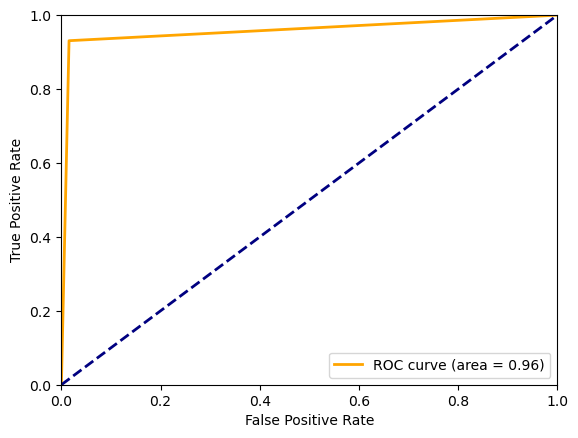

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


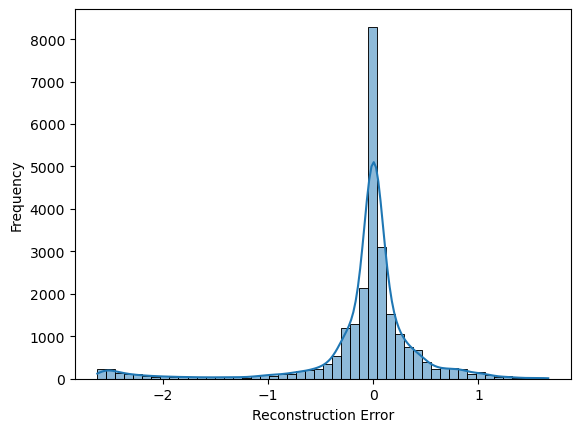

Final Model Performance
MSE Loss: 0.3543
MAE Loss: 0.3007
AUC: 0.96


In [279]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
import seaborn as sns

# Load bitstream data from file
data = pd.read_csv('Normal1_corrected.csv').dropna()


last_50_values = data.values[-50:]
golden_reference = np.full_like(last_50_values, 4.48)

# Compare the Checksums using MSE for a more accurate comparison
mse_checksum = ((last_50_values - golden_reference) ** 2).mean()
anomaly_detected = mse_checksum > 0.01  # Adjusted threshold
print(f"Checksums comparison - MSE: {mse_checksum:.4f}")
if anomaly_detected:
    print("The last 50 values deviate from the golden reference.")
else:
    print("The last 50 values are consistent with the golden reference.")

# Define losses
train_losses = []
val_losses = []
true_labels = []
predictions = []

# Split data into training and validation sets
train_data, val_data = train_test_split(data, test_size=0.3, random_state=42)

# Convert bitstream data to PyTorch tensors
tensor_train_data = torch.tensor(train_data.values, dtype=torch.float32)
tensor_val_data = torch.tensor(val_data.values, dtype=torch.float32)

# Normalize input data based on training data
mean = tensor_train_data.mean(dim=0)
std = tensor_train_data.std(dim=0)
tensor_train_data = (tensor_train_data - mean) / std
tensor_val_data = (tensor_val_data - mean) / std

# Define autoencoder architecture with reduced dropout
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(1, 64),  # Increased number of neurons
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 16),
            torch.nn.ReLU()
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(16, 32),  # Increased number of neurons
            torch.nn.ReLU(),
            torch.nn.Linear(32, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Instantiate autoencoder model
model = Autoencoder()

# Define loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

# Train autoencoder on bitstream data with early stopping
num_epochs = 100
patience = 20
count = 0
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Forward pass - Training
    model.train()
    train_outputs = model(tensor_train_data)
    train_loss = criterion(train_outputs, tensor_train_data)
    train_losses.append(train_loss.item())

    # Forward pass - Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(tensor_val_data)
        val_loss = criterion(val_outputs, tensor_val_data)
        val_losses.append(val_loss.item())

        # Collecting true labels and predictions for ROC calculation
        predictions.extend(val_outputs.numpy().flatten())
        true_labels.extend(tensor_val_data.numpy().flatten())

    # Backward and optimize - Training
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # Early stopping based on validation loss
    if val_loss.item() < best_val_loss - 0.01:
        best_val_loss = val_loss.item()
        count = 0
    else:
        count += 1
        if count == patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

# Binarize the true labels and predictions
threshold = np.median(true_labels)  # You can also try other thresholds like mean
binary_true_labels = np.array(true_labels) > threshold
binary_predictions = np.array(predictions) > threshold

# Compute ROC Curve and AUC
fpr, tpr, _ = roc_curve(binary_true_labels, binary_predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot Reconstruction Error Distribution
reconstruction_errors = np.array(predictions) - np.array(true_labels)
plt.figure()
sns.histplot(reconstruction_errors, bins=50, kde=True)
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
# plt.title('Reconstruction Error Distribution')
plt.show()

# Calculate and print performance metrics
mse_loss = criterion(torch.tensor(predictions), torch.tensor(true_labels))
mae_loss = torch.abs(torch.tensor(predictions) - torch.tensor(true_labels)).mean()

print(f"Final Model Performance")
print(f"MSE Loss: {mse_loss.item():.4f}")
print(f"MAE Loss: {mae_loss.item():.4f}")
print(f"AUC: {roc_auc:.2f}")
